* Time sequence forecasting challenge
* Data from Kaggle competition, but this kernel does NOT go into the item-store detail...only TOTAL SALES prediction by month
* Models: AR, MA, ARIMA, SARIMA and the winner ... FB Prophet  
* Each model RMSE on data available and predict 6 months ahead

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
from sklearn.metrics import mean_squared_error
from numpy import sqrt

import matplotlib.pyplot as plt # basic plotting
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns # for prettier plots

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scsor 

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
# Load data

sales=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
item_cat=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
item=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")

print('sales ' , sales.shape)
print('item_cat ' , item_cat.shape)
print('item ' , item.shape)
print('shops ' , shops.shape)


sales  (2935849, 6)
item_cat  (84, 2)
item  (22170, 3)
shops  (60, 2)


In [3]:
# formatting the date column from object to date time

print(sales.info())
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


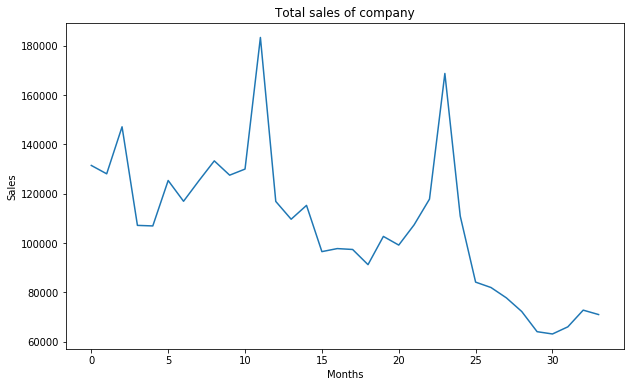

In [4]:
# Group by total monthly sales ...34 months

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(10,6))
plt.title('Total sales of company')
plt.xlabel('Months')
plt.ylabel('Sales')
indexedDataset = pd.DataFrame(ts)
#indexedDataset.head()
plt.plot(indexedDataset)
plt.show()

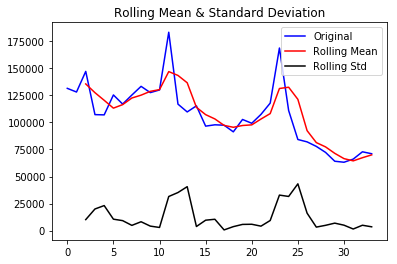

In [5]:
MyWindow = 3

#Determine rolling statistics
rolmean = indexedDataset.rolling(window=MyWindow).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=MyWindow).std()

#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

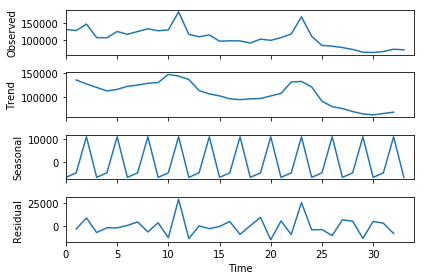

In [6]:
# decompose into trend, seasonality and residuals
res = sm.tsa.seasonal_decompose(indexedDataset.values,freq=MyWindow,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()

In [7]:
#Perform Augmented Dickey–Fuller test for stationarity

print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['item_cnt_day'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


# ARIMA

In [8]:
dataAR = list(indexedDataset.item_cnt_day.values)
len(dataAR)

34

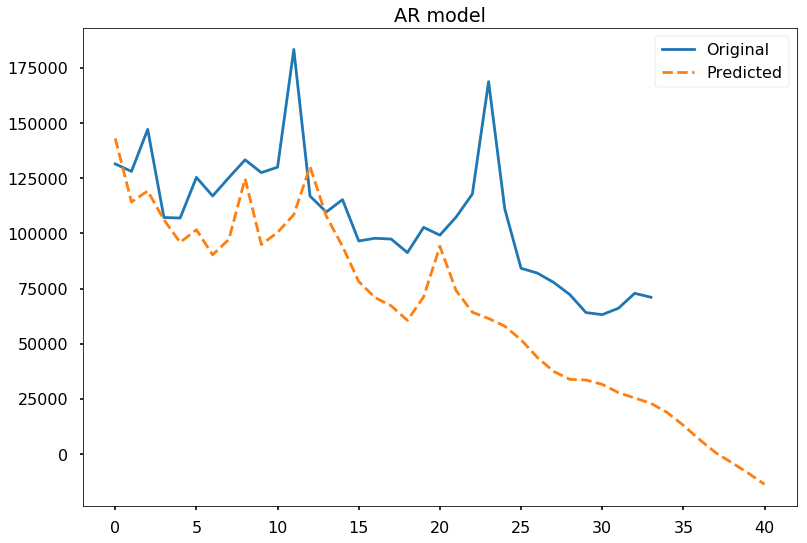

In [9]:
# AR model 

model = AR(dataAR)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(12, len(dataAR)+ 18) # predict N ahead of the last one

dataList = list(dataAR)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('AR model')
plt.show()

In [10]:
rmse = sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('AR RMSE: %.1f' % rmse)

AR RMSE: 37314.5


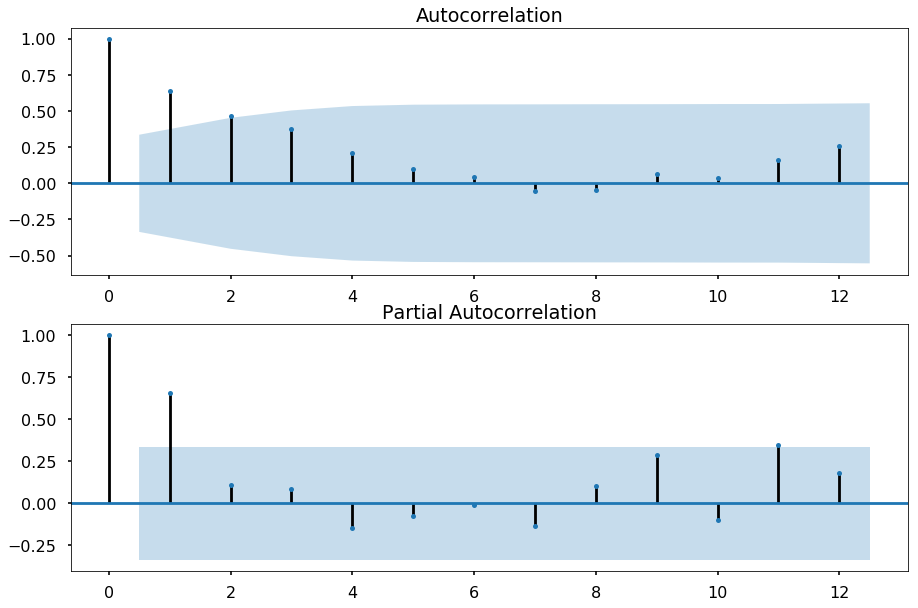

In [11]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
# Get p and q for ARIMA

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dataAR, lags=12, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dataAR, lags=12, ax=ax)
#plt.tight_layout()
plt.show()

Theoretically from the above charts, p = 4 and q = 7 ...supposedly, but these params do NOT work with SARIMA...

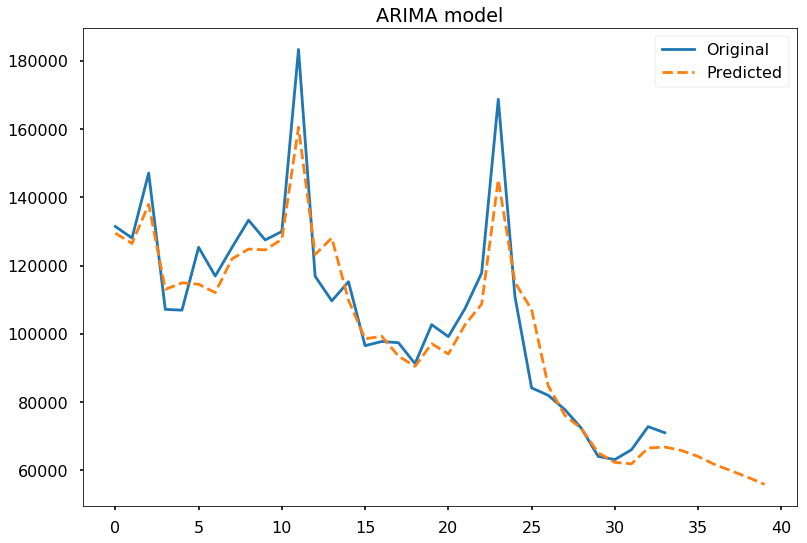

In [12]:
# ARIMA model

model = ARIMA(dataAR, order=(2, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(1, len(dataAR)+6, typ='levels')

dataList = list(dataAR)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('ARIMA model')
plt.show()

In [13]:
rmse = sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('ARIMA RMSE: %.1f' % rmse)

ARIMA RMSE: 8953.7


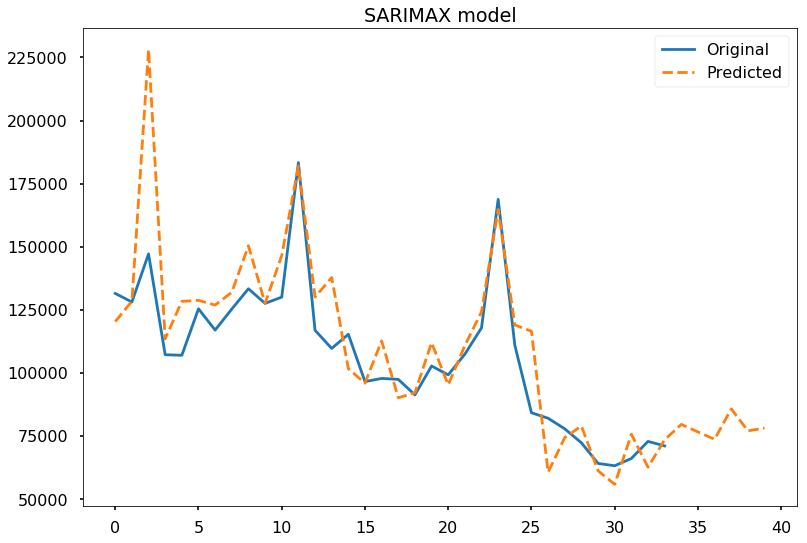

In [14]:
# SARIMA

model = SARIMAX(dataAR, order=(2, 1, 1), seasonal_order=(2,1,1,3))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(1, len(dataAR)+6)

dataList = list(dataAR)
yhatList = list(yhat)

plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(yhatList, ls='--', label='Predicted')
plt.legend(loc='best')
plt.title('SARIMAX model')
plt.show()

In [15]:
rmse = sqrt(mean_squared_error(dataList,yhatList[0:34]))
print('SARIMA RMSE: %.1f' % rmse)

SARIMA RMSE: 18295.1


# FB Prophet

In [16]:
# adding the dates to the Time-series as index ... required by FB Prophet
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [17]:
from fbprophet import Prophet
# prophet REQUIRES a pandas df at the below config 
# date column named as DS and the value column as Y
ts.columns=['ds','y']
model = Prophet(yearly_seasonality=True, weekly_seasonality=True) # instantiate Prophet with only yearly seasonality 
model.fit(ts) # fit the model with the ts dataframe

In [18]:
# predict for six months in the furure and MS - monthly = frequency
future = model.make_future_dataframe(periods = 6, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,131563.086475,130640.266632,132479.291412
1,2013-02-01,128610.972782,127727.876972,129543.446606
2,2013-03-01,146517.861673,145571.916996,147408.360636
3,2013-04-01,107951.862210,107009.715671,108814.433476
4,2013-05-01,106640.318317,105690.837607,107493.997084
5,2013-06-01,125088.903663,124188.813411,125972.295268
6,2013-07-01,115832.729730,114959.321214,116686.299367
7,2013-08-01,125503.540648,124647.102512,126423.041962
8,2013-09-01,133030.599302,132113.135725,133972.237397
9,2013-10-01,127927.361690,127039.565355,128809.202236


In [19]:
dataList = list(indexedDataset.item_cnt_day.values)

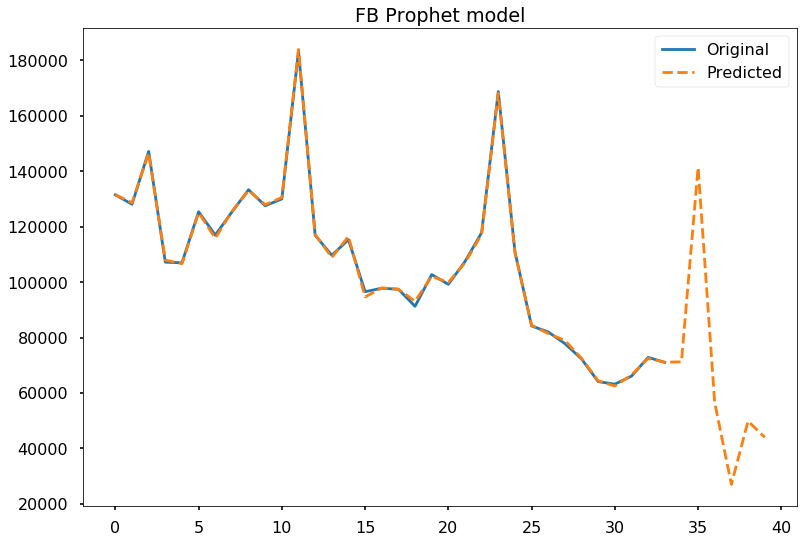

In [20]:
plt.style.use('seaborn-poster')
plt.figure()
plt.plot(dataList, label='Original')
plt.plot(forecast['yhat'], ls='--', label="Predicted")
plt.legend(loc='best')
plt.title('FB Prophet model')
plt.show()


In [21]:
# RMSE

rmse = sqrt(mean_squared_error(dataList,forecast['yhat'][0:34]))
print('Val RMSE: %.1f' % rmse)

Val RMSE: 708.1
